In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import warnings
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
cal = './bos_calendar.csv'
lis = './bos_listings.csv'
rev = './bos_reviews.csv'

In [5]:
'''
To extract data from bos_listings.csv and to load it into a DataFrame

'''

df_lis = pd.read_csv(lis)

In [6]:
'''
To cleanse and transform data for exploration.

'''

# To select only numeric data and to examine the composition.
df_num_test = df_lis.select_dtypes(include=['int64', 'float64'])
df_num_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 33 columns):
id                                3585 non-null int64
scrape_id                         3585 non-null int64
host_id                           3585 non-null int64
host_listings_count               3585 non-null int64
host_total_listings_count         3585 non-null int64
neighbourhood_group_cleansed      0 non-null float64
latitude                          3585 non-null float64
longitude                         3585 non-null float64
accommodates                      3585 non-null int64
bathrooms                         3571 non-null float64
bedrooms                          3575 non-null float64
beds                              3576 non-null float64
square_feet                       56 non-null float64
guests_included                   3585 non-null int64
minimum_nights                    3585 non-null int64
maximum_nights                    3585 non-null int64
has_availability    

In [9]:
# To isolate factors that by common logic will have most impact on listing price.
df_num = df_lis[['id','accommodates','bathrooms','bedrooms','number_of_reviews','review_scores_rating','reviews_per_month','calculated_host_listings_count']]
# To access how further data imputation will impact the distribution.
df_num.isnull().mean()

id                                0.000000
accommodates                      0.000000
bathrooms                         0.003905
bedrooms                          0.002789
number_of_reviews                 0.000000
review_scores_rating              0.226778
reviews_per_month                 0.210879
calculated_host_listings_count    0.000000
dtype: float64

In [11]:
# To fill missing numeric values with means.
warnings.filterwarnings('ignore')
df_num['bathrooms'].fillna(df_num['bathrooms'].mean(), inplace=True)
df_num['bedrooms'].fillna(df_num['bedrooms'].mean(), inplace=True)
df_num['review_scores_rating'].fillna(df_num['review_scores_rating'].mean(), inplace=True)
df_num['reviews_per_month'].fillna(df_num['reviews_per_month'].mean(), inplace=True)
df_num.isnull().mean()

id                                0.0
accommodates                      0.0
bathrooms                         0.0
bedrooms                          0.0
number_of_reviews                 0.0
review_scores_rating              0.0
reviews_per_month                 0.0
calculated_host_listings_count    0.0
dtype: float64

In [15]:
# To select only ctegorical data and to examine the composition.

df_obj_test = df_lis.select_dtypes(include=['object'])
df_obj_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 62 columns):
listing_url                         3585 non-null object
last_scraped                        3585 non-null object
name                                3585 non-null object
summary                             3442 non-null object
space                               2528 non-null object
description                         3585 non-null object
experiences_offered                 3585 non-null object
neighborhood_overview               2170 non-null object
notes                               1610 non-null object
transit                             2295 non-null object
access                              2096 non-null object
interaction                         2031 non-null object
house_rules                         2393 non-null object
thumbnail_url                       2986 non-null object
medium_url                          2986 non-null object
picture_url                         35

In [12]:
# To isolate factors that by common logic will have most impact on listing price.
df_obj = df_lis[['id','neighbourhood_cleansed','price','cleaning_fee']]
df_obj.notnull().mean()

id                        1.000000
neighbourhood_cleansed    1.000000
price                     1.000000
cleaning_fee              0.691213
dtype: float64

In [13]:
# To convert data in 'price' column to numeric and store it in 'listing_price' column.
df_obj['listing_price'] = np.nan
df_obj['price'] = df_obj['price'].astype(str)
df_obj['listing_price'][df_obj['price'].notnull()] =  df_obj['price'].apply(lambda x: re.sub('[$,]','',x)).astype(float)

# To convert data in 'cleaning_fee' column to numeric and store it in 'cleaning_charge' column.
df_obj['cleaning_charge'] = np.nan
df_obj['cleaning_fee'] = df_obj['cleaning_fee'].astype(str)
df_obj['cleaning_charge'][df_obj['cleaning_fee'].notnull()] =  df_obj['cleaning_fee'].apply(lambda x: re.sub('[$,]','',x)).astype(float)
df_obj['cleaning_charge'].fillna(df_obj['cleaning_charge'].mean(), inplace=True)

In [14]:
# To drop 'price' and 'cleaning_fee' columns. 
df_obj = df_obj.drop(columns=['price','cleaning_fee'])
df_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 4 columns):
id                        3585 non-null int64
neighbourhood_cleansed    3585 non-null object
listing_price             3585 non-null float64
cleaning_charge           3585 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 112.1+ KB


In [15]:
# To merge numeric data in df_num with categorical data in df_obj.
df_merge = df_obj.merge(df_num, on='id')
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3585 entries, 0 to 3584
Data columns (total 11 columns):
id                                3585 non-null int64
neighbourhood_cleansed            3585 non-null object
listing_price                     3585 non-null float64
cleaning_charge                   3585 non-null float64
accommodates                      3585 non-null int64
bathrooms                         3585 non-null float64
bedrooms                          3585 non-null float64
number_of_reviews                 3585 non-null int64
review_scores_rating              3585 non-null float64
reviews_per_month                 3585 non-null float64
calculated_host_listings_count    3585 non-null int64
dtypes: float64(6), int64(4), object(1)
memory usage: 336.1+ KB


In [18]:
# To convert categorical variable 'neighbourhood_cleansed' to dummy variables.
df_dum = pd.get_dummies(df_merge['neighbourhood_cleansed'])

# To determine the output and variables.
y = df_merge['listing_price']
X = df_merge.drop(columns=['neighbourhood_cleansed'])

In [19]:
# To the numeric variables with the dummy variables.
X = pd.concat([df_dum, X], axis=1)

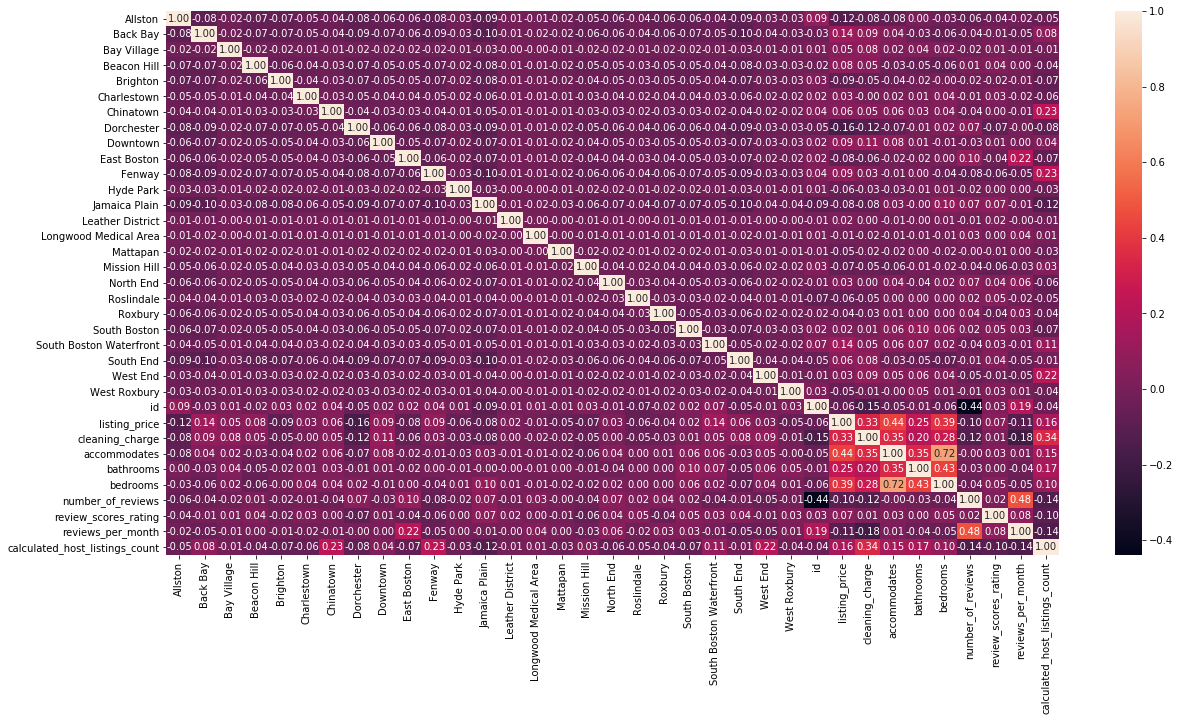

In [20]:
# To investigate the correlation between variables using Seaborn heatmap.
plt.figure(figsize=(20,10))
sns.heatmap(X.corr(), annot=True, fmt=".2f");

In [21]:
# To drop 'listing_price' from the variables.
X = X.drop(columns=['listing_price'])

In [23]:
# To divide the output and variables into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

# To fit the linear regression model and calcuate performace scores.
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

print(test_score, train_score)

0.27347926280201773 0.3979444317348526
